# 4. Wedge column test 1

Code to establish the relay for a single column in the mantle wedge using pyDEW and combined with interpolations from Guillaume's EQ3.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cmcrameri.cm as cmc
%cd ../
import pyDEW
%cd dev
from thermoengine import model
from copy import copy
from copy import deepcopy
from scipy.interpolate import LinearNDInterpolator

pd.options.mode.chained_assignment = None

In [2]:
# Function that may be helpful for expressing pressures as depths later
def geotherm(T, dTdz=50, rho=3.2):
    P = rho*T/dTdz
    return P

## A. Start by generating our interpolation grid from scratch

In [3]:
# Import the working EQ3 molalities data directly from the Excel file
DMMdata = pd.read_excel('Pickups_molalities_fO2_kw.xlsx', sheet_name='DMM')
MORBdata = pd.read_excel('Pickups_molalities_fO2_kw.xlsx', sheet_name='MORB')
SEDdata = pd.read_excel('Pickups_molalities_fO2_kw.xlsx', sheet_name='Sediments')

# use a dictionary to make the dataframes accessible
data = {'DMM': DMMdata,
        'MORB': MORBdata,
        'Seds': SEDdata}

dataLabels = list(data.keys())

## B. Build a single column

In [4]:
# columnDF = pd.read_csv('ASPECT_files/EQ6pointsp5kbar.csv')
# trenchDistanceList = []
# for i in columnDF['Trench distance (km)']:
#     if i not in trenchDistanceList:
#         trenchDistanceList.append(i)

# # Store our test case here        
# testDF = None

# # find first column where deepest point is within our interpolation grids
# for i in range(len(trenchDistanceList)):
#     trenchDistance = trenchDistanceList[i]
#     columnDFsub = columnDF[columnDF['Trench distance (km)'] == trenchDistance]
#     maxDepthIndex = columnDF['Pressure (kbar)'].idxmax()
#     if columnDFsub['Temperature (degC)'].iloc[maxDepthIndex] < 300:
#         continue
#     else:
#         testDF = columnDFsub
#         testDF.reset_index(inplace=True)
#         break


In [5]:
# This part isolates just one column for testing, in this case from a single csv
testDF = pd.read_csv('test_columnp5kb.csv')
#testDF = pd.read_csv('test_column1kb.csv')

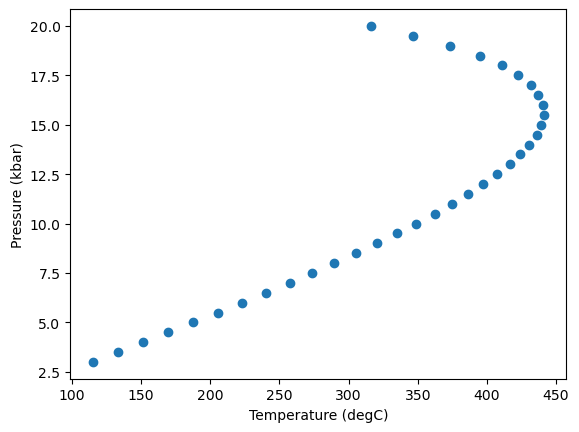

In [6]:
# Quick plots to see the structure of the wedge for our given column:
fig1, ax1 = plt.subplots()
ax1.scatter(testDF['Temperature (degC)'], testDF['Pressure (kbar)'])
ax1.set_xlabel('Temperature (degC)')
ax1.set_ylabel('Pressure (kbar)')
plt.show()

## C. Combine this column with pyDEW to see if a concept works

In [7]:
# Adjust here the basis species to be used in the DEW system - deepcopy to avoid mucking up defaults
defaultBasisSpecies = pyDEW.defaultsystem.basis_species_names
basisSpecies = deepcopy(defaultBasisSpecies)

defaultOtherSpecies = pyDEW.defaultsystem.other_species_names
otherSpecies = deepcopy(defaultOtherSpecies)

# Add missing Mg complex to the other species
otherSpecies.append('MG(OH)2(AQ)')

# Switch basis species - replace CO2(AQ) with CO3-2, placing CO3-2 directly where CO2(AQ) was to avoid pyDEW issues
basisSpecies[basisSpecies.index('CO2(AQ)')] = 'CO3-2'

# Create DEW system
dew_system = pyDEW.System(basis_species=basisSpecies, other_species=otherSpecies)

/opt/conda/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/opt/conda/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/opt/conda/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._phase_info = self._phase_info.append(phs_info, ignore_index=True)
/opt/conda/lib/python3.9/site-packages/thermoengine/model.py:184: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use panda

In [8]:
# pyDEW minutia - to match Guillaume's setups

# Suppress H2CO3(AQ)
nxmods = [['H2CO3(AQ)', 0, -1, 0]]

# List of reactants formed from mineral dictionaries
olvDict = {'reactant': 'OLIVINE(SS)',
           'moles': 5.9,
           'composition': {'FORSTERITE': 0.9, 'FAYALITE': 0.1}}

opxDict = {'reactant': 'ORTHOPYROXENE(SS)',
           'moles': 1.9,
           'composition': {'ENSTATITE_OR': 0.9, 'FERROSILITE': 0.1}}

cpxDict = {'reactant': 'CLINOPYROXENE(SS)',
           'moles': 0.2,
           'composition': {'DIOPSIDE': 0.9, 'HEDENBERGITE': 0.1}}

spnDict = {'reactant': 'SPINEL',
           'moles': 0.04}

reactants = [olvDict, opxDict, cpxDict, spnDict]

# List of species to export
exportSpecies = ['NA+', 'CA+2', 'MG+2', 'AL+3', 'H4SIO4(AQ)', 'H+', 'CO3-2', 'CL-', 'FE+2']

In [9]:
# Determine starting PT from testDF

# First make sure everything is nice and formatted
columnP = [i*1000 for i in testDF['Pressure (kbar)']]  # convert to bars
columnT = [i+273.15 for i in testDF['Temperature (degC)']]  # convert to K

# Make sure we start from the bottom up
if columnP[-1] == max(columnP):  # If the deepest value is at the end of the list, flip both around
    columnP.reverse()
    columnT.reverse()

startingP = columnP[0]
startingT = columnT[0]

In [10]:
# Get our molalities for all lithologies for the initial EQ3 run
molalitiesDict = {}

# Iterate over all lithologies
for i in range(len(data)):
    key = dataLabels[i]
    keyData = data[key]

    # Extract list of species 
    columnHeaders = list(keyData.columns)
    speciesHeaders = columnHeaders[2:]

    # Extract pressures and temperatures
    P = keyData['P (kbar)'].values
    T = keyData['T (degC)'].values
    
    # This is Cell 9 from 1_3d_plotter, which iterates over all species and linearly interpolates between them 
    for j in range(len(speciesHeaders)):
        speciesData = keyData[speciesHeaders[j]]
        diffCheck = True

        # Makes sure that the species aren't all constant, which makes the interpolation wacky
        if speciesData.tolist() == [speciesData.tolist()[0]]*len(speciesData):
            molalitiesDict[speciesHeaders[j]+'_'+key] = speciesData[0]

        # Otherwise we set up the interpolator for the species given pressure and temperature
        else:
            interp = LinearNDInterpolator(list(zip(T.tolist(), P.tolist())), speciesData.tolist())
            interpMolal = interp(startingT-273.15, startingP/1000)  # key to reconvert back to original units here
            molalitiesDict[speciesHeaders[j]+'_'+key] = float(interpMolal)

In [11]:
# Lists for storage
fO2s = []
pH = []

# Iterate over all pressures in the column
for i in range(len(columnP)):
    workingP = columnP[i]
    workingT = columnT[i]
    
    # if we are just starting, we want to pull the EQ3 fluid data from the datafile
    if i == 0:
        # Create our starting EQ3 fluid
        # Fluid molalities from above. Here we use the values for DMM only as a test
        molalitiesDMM = {'NA+': molalitiesDict['NA_DMM'],
                         'CA+2': molalitiesDict['CA_DMM'],
                         'MG+2': molalitiesDict['MG_DMM'],
                         'AL+3': molalitiesDict['AL_DMM'],
                         'H4SIO4(AQ)': molalitiesDict['SI_DMM'],
                         'CO3-2' : molalitiesDict['C_DMM'],
                         'CL-': molalitiesDict['CL_DMM'],
                         'FE+2': molalitiesDict['FE_DMM']}
        print('hi')
        # Select DMM fO2 which is interpolated from above - can try different values here if needed to. Interpolation is a bit iffy but works as a first pass
        fO2DMM = molalitiesDict['fO2_DMM']
        dewFluid = pyDEW.Fluid(dew_system, workingT, workingP, molalities=molalitiesDMM, fO2=-20.0,
                               uebal='H+', uacion='CL-', nxmods=nxmods, aH2O_mode='molfraction')
        print('hi')
    else:
        # Use the final results of that calculation
        molalitiesDMM = {'NA+': lastElements['Na'],
                         'CA+2': lastElements['Ca'],
                         'MG+2': lastElements['Mg'],
                         'AL+3': lastElements['Al'],
                         'H4SIO4(AQ)': lastElements['Si'],
                         'CO3-2' : lastElements['C'],
                         'CL-': lastElements['Cl'],
                         'FE+2': lastElements['Fe']}
        molalitiesDMM.update((k, 10**v) for k, v in molalitiesDMM.items()) # All reported as log(molal) in pyDEW output
        fO2DMM = dewReaction.fO2[-1]
        
        dewFluid = pyDEW.Fluid(dew_system, workingT, workingP, molalities=molalitiesDMM, fO2=-20.0,
                               uebal='H+', uacion='CL-', nxmods=nxmods, aH2O_mode='molfraction')
    print(fO2DMM)
    print(molalitiesDMM)
    dewReaction = pyDEW.Reaction(dewFluid, workingT, workingP, reactants, calculation_mode='titration')
    pH.append(dewReaction.pH[-1])
    lastElements = dewReaction.elements.iloc[-1]
    lastSpecies = dewReaction.species_concs.iloc[-1]
    
    # If we are just starting, create a new dataframe
    if i == 0:
        elementsDF = lastElements.to_frame().T
        speciesDF = lastSpecies.to_frame().T
    # else concat to the previous dataframe which has been created
    else:
        tempElementsDF = lastElements.to_frame().T
        elementsDF = pd.concat([elementsDF, tempElementsDF])
        tempSpeciesDF = lastSpecies.to_frame().T
        speciesDF = pd.concat([speciesDF, tempSpeciesDF])
    fO2s.append(fO2DMM)
    print('done ' + str(workingP/1000))  # For tracking progress
    
    # # Debugging break
    # if workingP == 17500:  # this pressure because in the 0.5 run this is where the thing breaks
    #     break
speciesNames = list(dewReaction.species_concs.columns)
speciesDF.reset_index(inplace=True)
elementsDF.reset_index(inplace=True)


hi
hi
-34.03287343204432
{'NA+': 35.4521139595983, 'CA+2': 0.00034088280073158274, 'MG+2': 0.36465241802135917, 'AL+3': 0.003087527417462727, 'H4SIO4(AQ)': 0.07059232738963753, 'CO3-2': 0.0010000000002374752, 'CL-': 0.010000000000401727, 'FE+2': 0.00017914134154896385}
done 20.0
-37.0072
{'NA+': 36.58474227939712, 'CA+2': 2.2929785918248233e-05, 'MG+2': 0.3783554551232311, 'AL+3': 0.0003548133892335753, 'H4SIO4(AQ)': 0.0801678063387679, 'CO3-2': 0.0010318106352675918, 'CL-': 0.010318106352675924, 'FE+2': 0.0003023430570511337}


KeyboardInterrupt: 

In [ ]:
# speciesDF.to_csv('speciesp5kbar.csv')
# elementsDF.to_csv('elementsp5kbar.csv')

In [ ]:
#print(speciesDF.columns)
columnPkbar = [P/1000 for P in columnP]
fig2, ax2 = plt.subplots()
ax2.scatter(speciesDF['METHANE(AQ)'], columnPkbar, c='r', label='Aqueous CH4')
ax2.scatter(speciesDF['H2(AQ)'], columnPkbar, c='b', label='Aqueous H2')
ax2.set_xlabel('log(molality)')
ax2.set_ylabel('Pressure (kbar)')
ax2.invert_yaxis()
ax2.legend()
plt.show()

In [ ]:
fig3, ax3 = plt.subplots()
ax3.scatter(pH, columnPkbar)
ax3.set_xlabel('pH')
ax3.set_ylabel('Pressure (kbar)')
ax3.invert_yaxis()
plt.show()